<a href="https://colab.research.google.com/github/nneibaue/etsp_explorer/blob/master/etsp_data_explorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>ETSP Data Explorer</h1>

This notebook is written to provide some basic visualization tools in Python using some of Colab's nice output features. It's fairly basic, but should provide a decent example of how Python and Colab can be useful for something like this. Google provides a free runtime in the cloud, so no need to install Python and set anything up on the computer. The free version of Colab has more than enough features, memory, and drive space for our purposes here 


## Research Context

Samples are collected at different depths for a given location in the ocean (e.g. lat, long). Each of these samples is measured for concentrations of various different elements via a 2D scan, yielding concentration values at individual pixels. A given pixel may contain a non-trivial concentration value for one or more elements. 

It is of particular interest how a given element (Cu in this case) is distributed among different element groups for a given scan. For example, one pixel could contain non-trivial concentrations of Cu, Mg, Br, and Zn, whereas another pixel might only contain Fe and Mg. 


## Problem Statement

* Given a dataset for a single location, how does the distribution of an element vary with depth? Assumptions include:
  * There can be many scans at a given depth
  * No two scans overlap in space
  * Concentration values ($[x]$) at a pixel are only considered non-trivial if:
  $$
  [x] > \bar{[x]} + 2 \cdot \sigma_x 
  $$
  where $\bar{[x]}$ is the average concentration value and $\sigma$ is the standard deviation
  * Concentration values filtered by an element are only considered non-trivial if the element in question satisfies the above condition
    * E.g. a pixel may contain non-trivial amounts of Ca and Mg, but not Cu. If we are filtering by Cu, then this pixel is rejected


**Please don't edit this notebook directly. To make changes, first make a copy of the notebook.**

#Setup

##Imports

In [0]:
from google.colab import drive
from google.colab import widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import iplot
import random
import re
from functools import reduce
#from IPython import display, html
import altair as alt
from IPython.display import display, HTML
from cycler import cycler
#Namespace class to keep things organized
class Namespace:
  def __init__(self, **kwargs):
    self.__dict__.update(**kwargs)

## Connecting Google Drive

Run the following cell, then follow the instructions to link this notebook with Google drive

In [2]:
drive.mount('/content/gdrive')
DRIVE_BASE = '/content/gdrive/My Drive'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Definitions

###Detsum

In [0]:
class Detsum:
  file_template = '^detsum_([a-zA-Z]{1,2})_([A-Z])(_norm)?.txt$'
  def __init__(self, path, filter=True):
    self.filename = path.split('/')[-1]
    self.scan_name = path.split('/')[-2]
    self.depth = path.split('/')[-3]
    if re.search('_norm.txt', self.filename):
      self.normalized = True
    else:
      self.normalized = False
    if not re.fullmatch(Detsum.file_template, self.filename):
      raise NameError(f'{self.filename} is not a valid name for Detsum')
    self.element = re.search(Detsum.file_template, self.filename).group(1)
    self.orbital = re.search(Detsum.file_template, self.filename).group(2)

    self._data_raw = np.array(np.genfromtxt(path))
    self.default_mask = self._create_default_mask(self._data_raw)
    self.masks = []
    if filter:
      self.masks.append(self.default_mask)


  @property
  def data(self):
    return self._apply_masks(self._data_raw)

  @property
  def total_counts(self):
    return np.nansum(self.data)

  def _apply_masks(self, data):
    data = data.copy()
    mask = np.logical_and.reduce(self.masks)
    data[~mask] = np.nan
    return data


  def _filter_func(self, x, num_std=2):
    return np.mean(x) + num_std * np.std(x)

  def _create_default_mask(self, data):
    interesting_points = data > self._filter_func(data)
    return interesting_points

  def add_mask(self, mask):
    '''Removes points that aren't in the mask'''
    assert mask.shape == self.data.shape
    self.masks.append(mask)

  def reset_mask(self):
    self.masks = []
    if filter:
      self.masks.append(self.default_mask)

  def plot(self, raw=False,
           figsize=(7, 7),
           ax=None,
           **imshow_kwargs):

    if ax is None:
      fig, ax = plt.subplots(figsize=figsize)
    else:
      fig = ax.figure
    if raw:
      ax.imshow(self._data_raw, **imshow_kwargs)
    else:
      ax.imshow(self.data, aspect='equal', **imshow_kwargs)
    ax.set_title(self)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

  # def __add__(self, other):
  #   return self._create_default_mask(tot)

  def __repr__(self):
    return (f'Detsum(element: {self.element}, ' 
            f'orbital: {self.orbital}, ' 
            f'normalized: {self.normalized}, '
            f'total counts: {self.total_counts}')



###Scan

In [0]:
class Scan:
  file_template = '^scan2D_([0-9]{4,7})$' # Assume scan number < 1E6

  def __init__(self, path,
               elements_of_interest=None,
               orbitals=['K'],
               normalized=True,
               filter=True):
    self.depth = path.split('/')[-2]
    self.name = path.split('/')[-1]
    self._elements_of_interest = elements_of_interest
    self._orbitals = orbitals
    self._normalized = normalized
    self._filter = filter
    if not re.fullmatch(Scan.file_template, self.name):
      raise NameError(f'{path} is not a valid name for Scan directory')
    else:
      self.path = path

    self.scan_number = re.search(Scan.file_template, self.name).group(1)

    # Build regex template based on parameters
    template = '^detsum'
    if elements_of_interest is None:
      template += '[a-zA-Z]{1,2}'
    else:
      template += f'_({"|".join(elements_of_interest)})'
    template += f'_({"|".join(orbitals)})'
    if normalized:
      template += '_norm.txt$'
    else:
      template += '.txt$'
    self._template = template  
    self.detsums = self._make_detsums(template)
    self.detsums = sorted(self.detsums, key = lambda d: d.element)
    self.test = 'test'

  def _get_element_groups(self):
    elements = np.array(self.elements)
    data = np.stack([d.data for d in self.detsums], axis=2)
    groups = np.zeros_like(data[..., 0]).astype(str)
    unique_elements = {}
    for i, row in enumerate(data):
      for j, _ in enumerate(row): 
        pixel = data[i, j]
        group_elements = elements[~np.isnan(pixel)]
        group_name = '|'.join(group_elements)
        groups[i, j] = group_name
    return groups

  def get_unique_groups(self, elements_to_sum=['Cu'], sort_by='counts'):
    if sort_by not in (['num_pixels'] + [f'{element}_counts' for element in elements_to_sum]):
      raise ValueError("`sort_by` must be 'pixels' or '{element}_counts'")
    data = self.data
    aggfunc = {element: np.sum for element in elements_to_sum}
    aggfunc.update(element_group = 'count')
    res = pd.pivot_table(data,
                         index='element_group',
                         aggfunc=aggfunc)
    res.columns=[f'{element}_counts' for element in elements_to_sum] + ['num_pixels']
    return res.sort_values(by=sort_by, ascending=False)

  def get_detsum(self, element):
    assert element in self.elements
    return self.detsums[self.elements.index(element)]

  @property
  def elements(self):
    return [d.element for d in self.detsums]

  @property
  def data(self):
    df = pd.DataFrame()
    for d in self.detsums:
      df[d.element] = d.data.ravel()

    df['element_group'] = self._get_element_groups().ravel()
    df = df.replace('^$', np.nan, regex=True)
    return df

  @property
  def concentrations(self):
    df = pd.DataFrame()
    for d in self.detsums:
      df[d.element] = [d.total_counts]
    return df


  def plot_concentrations(self,
                          against='Cu',
                          elements=None,
                          single_figsize=(5, 5)):

    ncols = 2
    nrows = int(np.ceil(len(self.detsums) / ncols))
    f = plt.figure(figsize=(ncols*single_figsize[0], nrows*single_figsize[1]))
    x = self.detsums[list(map(lambda d: d.element, self.detsums)).index(against)]

    #Make axes
    for i, d in enumerate(self.detsums):
      a = f.add_subplot(f'{nrows}{ncols}{i}')
      #a = f.add_subplot(f'{nrows}{ncols}{i}')
      a.scatter(x.data.ravel(), d.data.ravel())
      a.set_xlabel(x.element, fontsize=14, fontweight='bold')
      a.set_ylabel(d.element, fontsize=14, fontweight='bold')
      a.text(0.5, 0.9, f'{d.element} total: {d.total_counts:0.4f}', transform=a.transAxes)
      a.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
      a.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
      f.suptitle(f'Scan {self.scan_number}', y=0.9, fontsize=16, fontweight='bold')
     

  def interactive_plot(self,
                       element='Cu',
                       display=True,
                       save=False,
                       filename='altair_dashboard.html',
                       base_dir=DRIVE_BASE):
    # Only select pixels that have Cu values
    cu_points = self.data[self.data[element].notnull()]
    alt.data_transformers.disable_max_rows()
    cu_points['num_present_elements'] = cu_points['element_group'].apply(lambda x: len(x.split('|')))
    
    
    #unpivot the table into a new table with ['pixel', 'element', 'concentration']
    cu_points_melted = cu_points.melt(
        id_vars='element_group',
        value_vars=self.elements,
        var_name='element',
        value_name='concentration')
    
    
    selection = alt.selection_multi(fields=['element_group'])
    
    #base bar chart
    bar_base = alt.Chart(cu_points_melted).transform_filter(
        selection
        ).encode(
        y='element',
        x='sum(concentration)',
        text=alt.Text('sum(concentration)', format='0.2f')
    )
    
    #function to create scatter plot based on element
    scatter_base = lambda e: alt.Chart(cu_points).mark_circle().encode(
        x=element,
        y=e,
        tooltip=self.elements,
        color=alt.condition(selection, 'element_group:N', alt.value('lightgray'), legend=None)
    ).add_selection(
        selection
    )
    
    counts = alt.Chart(cu_points).transform_filter(
        selection
    ).transform_aggregate(
        count='count()'
    ).transform_calculate(
        text="number of points selected: " + alt.datum.count
    ).mark_text(
        dy=-20,
        baseline="top",
        align="left"
    ).encode(
        x=alt.value(100),
        y=alt.value(5),
        text='text:N',
    )
  
    # legend plot
    legend = alt.Chart(cu_points).mark_circle(size=100).encode(
        x='element_group:N',
        color=alt.condition(selection, 'element_group:N', alt.value('lightgray'))
    ).add_selection(
        selection
    )
    
    #bar plots
    bar_final = bar_base.mark_bar()
    bar_text = bar_base.mark_text(align='left', baseline='middle', dx=3)
    
    #scatter plots
    scatters = alt.vconcat(
        *[alt.hconcat(
            *[(scatter_base(e).properties(width=300, height=150) + counts)
            for e in self.elements[i:i+3] if e != 'cu']
        )
        for i in range(0, len(self.elements) - 1, 3)]
    )
    
    
    #final plot, put together with altair's fancy syntax
    final_plot = alt.vconcat(scatters, legend | (bar_final + bar_text), center=True)
  
    if save:
      final_plot.save(os.path.join(base_dir, filename))
    
    if display:
      return final_plot 
  
  # a = altair_plot(display=true,
  #             save=false,
  #             base_dir=drive_base + '/naomi_data_viz/', 
  #             filename='altair_dashboard.html')
  # a

  def _make_detsums(self, template):
    detsums = []
    for f in os.listdir(self.path):
      fullpath = os.path.join(self.path, f)
      #print(self._template, f, re.fullmatch(self._template, f))
      if re.fullmatch(self._template, f):
        detsums.append(Detsum(fullpath))
    for d in detsums:
      self.__dict__[f'{d.element}_{d.orbital}'] = d
    return detsums
  
  def __repr__(self):
    nl = '\n'
    #detsums = '\n'.join([str(d) for d in self.detsums])
    return (f'Scan(scan_number: {self.scan_number}, contained_detsums:{nl}'
            f'{nl.join(map(str, self.detsums))})')

  #def plot_all_detsums(self, raw=True)


  def filter_by(self, element):
    # Create a new scan object
    s = Scan(self.path,
             self._elements_of_interest,
             self._orbitals,
             self._normalized,
             self._filter)

    # Extract the mask from the element of interest
    for d in s.detsums:
      if d.element == element:
        mask = d.default_mask

    # Add mask to other detsums 
    for d in s.detsums:
      if d.element != element:
        d.add_mask(mask)
    return s



####CombinedScan

In [0]:
class CombinedScan(Scan):
  def __init__(self, scans):
    
    #make sure all scans are at the same depth
    assert len(set([s.depth for s in scans])) == 1

    self.depth = scans[0].depth
    self._scans = scans


  @property
  def data(self):
    scan_data = [s.data for s in self._scans]
    return pd.concat(scan_data, ignore_index=True)
  
  def filter_by(self, element):
    new_scans = [s.filter_by(element) for s in self._scans]
    return CombinedScan(new_scans) 

  def get_detsum(self, element):
    detsums = []
    for s in self._scans:
      assert element in s.elements
      detsums.append(s.detsums[s.elements.index(element)])
    return detsums

  def __repr__(self):
    scans = '\n'.join([f'{s.__repr__()}\n--------------------\n' for s in self._scans])
    return f'CombinedScan\n===================\n{scans})'
           

###Depth

In [0]:
class Depth:
  file_template = '^([0-9])+m$'
  def __init__(self, path,
               elements_of_interest=None,
               orbitals=['K'],
               normalized=True):
    self.scans = []
    self.name = path.split('/')[-1]
    if not re.fullmatch(Depth.file_template, self.name):
      raise NameError(f'{self.name} is not a valid name for a Depth!')
    #self.depth = re.search(Depth.file_template, path.split('/')[-1]).group(1)
    self.depth = path.split('/')[-1]
    for f in os.listdir(path):
      fullpath = os.path.join(path, f)
      try:
        self.scans.append(
            Scan(fullpath,
                 elements_of_interest=elements_of_interest,
                 orbitals=orbitals,
                 normalized=normalized))
      except NameError as e:
        print(e)
        pass

  @property
  def combined_scan(self):
    return CombinedScan(self.scans)
  
  @property
  def elements(self):
    '''Returns the elements present in all scans'''
    return sorted(list(reduce(set.intersection, [set(s.elements) for s in self.scans])))

  @property
  def summary(self):
    pass

  @property
  def concentrations(self):
    df = pd.DataFrame()
    df.columns = self.elements
    for s in self.scans:
      df.loc[s.scan_number] = s.concentrations
    df.index.name = 'Scan Number'
    return df

  def __repr__(self):
    return f'Depth({self.depth}, scans: {[s.scan_number for s in self.scans]})'
    

## Data Structures 

This notebook leverages 4 different objects: 
* `Depth`
* `Scan`
* `CombinedScan`
* `Detsum`

`Depth` is the top level container object. It holds various different `Scan` objects, as well as a single `CombinedScan` object. `Scan` objects hold various `Detsum` objects pertaining to particular elements, orbitals, and normalization information. As mentioned above, instantiating a `Depth` object will automatically create the required `Scan` (and thus `Detsum`) objects. 

----
`Detsum` objects are associated with a particular element and orbital. A single `Scan` can hold many of these.

---
`Scan` objects do most of the heavy lifting, and we will see in the examples below how to use the provided methods.

---
`CombinedScan` objects behave similarly to Scan objects, and are used to collapse several scans into a single set of data.

---
This object structure mirrors the directory structure that contains all data. File and directory names must be formatted according to the following.

* `Depth` directories: "\<depth_in_meters>m"
  * "40m"
  * "150m"
* `Scan` directories: "scan2D_\<scan_number>"
  * "scan2D_21361"
  * "scan2D_28872"
* `Detsum` files: "detsum_\<element>_\<orbital>(_norm).txt"
  * "detsum_Zn_K_norm.txt"
  * "detsum_Tb_L.txt"

An example folder directory might look like this:
>40m
>>scan2D_28872
>>>detsum_Fe_K_norm.txt
>>>detsum_Sr_L_norm.txt
>>>detsum_Cu_K_norm.txt 

>>scan2D_21361
>>>detsum_Fe_K_norm.txt
>>>detsum_Sr_L_norm.txt
>>>detsum_Cu_K_norm.txt 

>100m
>> ..
>>> ..


It is ok to have other files in the data folders. If the names do not match the conventions described above, the code will simply skip over these files.

##Examples

The following cells demonstrate how to work with the various objects defined above. Note that in these examples, Detsum and Scan objects are instantiated (brought into existence) directly, but in practice, this will happen automatically with an instantiation of a Depth object.

###Detsum object

To instantiate a detsum object, we just pass in the filename and an optional `filter` parameter. If `filter` is a boolean that determines whether or not the uninteresting points are filtered out based on a hardcoded filter function.

In [7]:
DetsumExample = Namespace() # Using Namespace to keep global variables from getting all over the place
DetsumExample.filepath = os.path.join(DRIVE_BASE, "software_development/etsp/XRF data/25m/scan2D_28903/detsum_Cu_K_norm.txt") 

# Creating a Detsum object
DetsumExample.d = Detsum(DetsumExample.filepath, filter=True) #passing `filter=True` will apply the 'non-trivial' filter defined at the top of the notebook

# Printing a Detsum object to the output
DetsumExample.d

Detsum(element: Cu, orbital: K, normalized: True, total counts: 0.18512200471013784

In [8]:
# Accessing some properties of the detsum object
print('element: ', DetsumExample.d.element)
print('oribital: ', DetsumExample.d.orbital)
print('total counts: ', DetsumExample.d.total_counts)
print('scan name: ', DetsumExample.d.scan_name)
print('depth: ', DetsumExample.d.depth)

element:  Cu
oribital:  K
total counts:  0.18512200471013784
scan name:  scan2D_28903
depth:  25m


,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

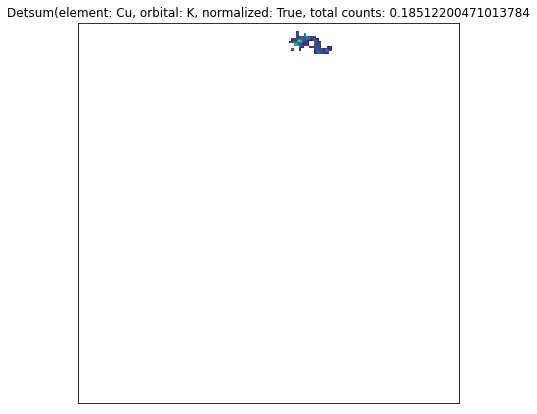

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

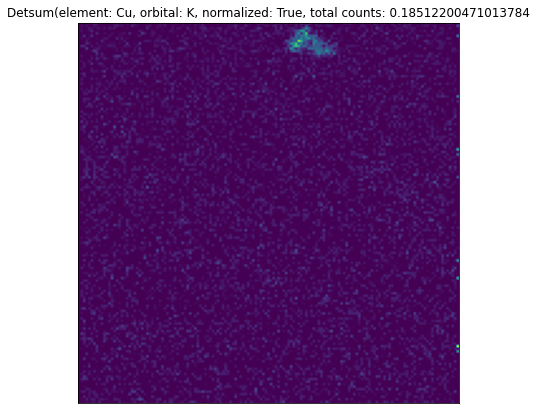

<IPython.core.display.Javascript object>

In [9]:
#Plot the filtered or unfiltered data
DetsumExample.g = widgets.Grid(1, 2)
with DetsumExample.g.output_to(0, 0):
  DetsumExample.d.plot()
with DetsumExample.g.output_to(0, 1):
  DetsumExample.d.plot(raw=True)

In [10]:
# Get the data. `nan` values have been filtered out by the default filter
DetsumExample.d.data

array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
        0.0002895],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]])

### Scan object

In [11]:
#Create a Scan object
ScanExample = Namespace()
ScanExample.scan_path = os.path.join(DRIVE_BASE, "software_development/etsp/XRF data/25m/scan2D_28903")
ScanExample.s = Scan(ScanExample.scan_path,
                     elements_of_interest=['Ca', 'Cu', 'Fe'], # Only look for these elements in the scan folder
                     orbitals=['K'], # Only look for 'K' orbitals
                     normalized=True, # Only look for files that end in _norm.txt, as described above
                     filter=True) # Passed into the constructor for all Detsums that will be created

# Print Scan to output
ScanExample.s

Scan(scan_number: 28903, contained_detsums:
Detsum(element: Ca, orbital: K, normalized: True, total counts: 14.91428297990933
Detsum(element: Cu, orbital: K, normalized: True, total counts: 0.18512200471013784
Detsum(element: Fe, orbital: K, normalized: True, total counts: 3.724888182245195)

<h3>Filtering by different elements</h3>

The `filter_by` method of the `Scan` class will filter out all pixels that do not contain non-trivial concentrations of the element passed in to `filter_by`.

In [12]:
ScanExample.s.filter_by('Cu')

Scan(scan_number: 28903, contained_detsums:
Detsum(element: Ca, orbital: K, normalized: True, total counts: 1.0958764641545713
Detsum(element: Cu, orbital: K, normalized: True, total counts: 0.18512200471013784
Detsum(element: Fe, orbital: K, normalized: True, total counts: 0.0667419321835041)

<h3>Accessing Detsums</h3>



In [13]:
# First method
ScanExample.s.get_detsum('Cu')

Detsum(element: Cu, orbital: K, normalized: True, total counts: 0.18512200471013784

In [14]:
# Alternatively
ScanExample.s.Cu_K

Detsum(element: Cu, orbital: K, normalized: True, total counts: 0.18512200471013784

In [15]:
# Get all detsums
ScanExample.s.detsums

[Detsum(element: Ca, orbital: K, normalized: True, total counts: 14.91428297990933,
 Detsum(element: Cu, orbital: K, normalized: True, total counts: 0.18512200471013784,
 Detsum(element: Fe, orbital: K, normalized: True, total counts: 3.724888182245195]

<h3>Accessing Pixel Data</h3>

Calling Scan.data will return a Pandas dataframe with all Detsum data flattened into individual columns. Each row represents a single pixel, and the last column gives a string representing the element group

In [16]:
ScanExample.data = ScanExample.s.filter_by('Cu').data 
ScanExample.data.dropna(how='all') # Filter out rows (pixels) that have all NaN

,Ca,Cu,Fe,element_group
6,NaN,0.000151,NaN,Cu
22,NaN,0.000156,NaN,Cu
86,0.016473,0.000161,NaN,Ca|Cu
89,0.013691,0.000148,NaN,Ca|Cu
117,NaN,0.000174,NaN,Cu
...,...,...,...,...
22523,NaN,0.000303,NaN,Cu
22524,NaN,0.000195,NaN,Cu
22695,NaN,0.000165,NaN,Cu
22731,NaN,0.000227,NaN,Cu


<h3>Getting unique element groups</h3>

This method returns the unique groups found in a particular scan, sorted in descending order by number of counts ($[x]$) or number of pixels containing that group. These are not necessarily the same values because individual pixels could contain high or low concentrations of a given *element*

In [17]:
# Get groups, show Cu and Fe counts, and sort by Cu counts
ScanExample.s.get_unique_groups(elements_to_sum=['Cu', 'Fe'], sort_by='Fe_counts')


,Cu_counts,Fe_counts,num_pixels
element_group,,,
Fe,0.000000,3.383277,256
Ca|Fe,0.000000,0.274869,24
Cu|Fe,0.002045,0.066742,10
Ca,0.000000,0.000000,919
Ca|Cu,0.029830,0.000000,83
Cu,0.153247,0.000000,715


In [18]:
# Filter by Cu, show Cu, Fe, and Ca counts, and sort by pixels
ScanExample.s.filter_by('Cu').get_unique_groups(elements_to_sum=['Cu', 'Fe', 'Ca'],
                                                sort_by='num_pixels')

,Cu_counts,Fe_counts,Ca_counts,num_pixels
element_group,,,,
Cu,0.000000,0.153247,0.000000,715
Ca|Cu,1.095876,0.029830,0.000000,83
Cu|Fe,0.000000,0.002045,0.066742,10


<h3>Interactive Plot</h3>

Calling `Scan.interactive_plot()` generates a nice dashboard that allows you to select individual element groups and look at the relative concentration values

In [19]:
ScanExample.s.interactive_plot(element='Cu')

alt.VConcatChart(...)

In [20]:
ScanExample.s.interactive_plot(element='Fe')

alt.VConcatChart(...)

###CombinedScan object

For now, the CombinedScan class is a subclass (or child class) of the Scan object, but with reduced (or modified) functionality. 

<h3>Creating a CombinedScan</h3>

`CombinedScan` objects take in a list of `Scans` as the only argument in the constructor

In [21]:
CombinedScanExample = Namespace()
CombinedScanExample.scan_root = os.path.join(DRIVE_BASE, "software_development/etsp/XRF data/25m")
CombinedScanExample.scan_names = os.listdir(CombinedScanExample.scan_root)

# Create some scans
CombinedScanExample.scans = []
for name in CombinedScanExample.scan_names:
  CombinedScanExample.scans.append(
      Scan(os.path.join(CombinedScanExample.scan_root, name),
           elements_of_interest=['Ca', 'Cu', 'Fe'],
           orbitals=['K'],
           normalized=True,
           filter=True)
  )

# Create CombinedScan
CombinedScanExample.cs = CombinedScan(CombinedScanExample.scans)

CombinedScanExample.cs

CombinedScan
Scan(scan_number: 28861, contained_detsums:
Detsum(element: Ca, orbital: K, normalized: True, total counts: 1.026225390844047
Detsum(element: Cu, orbital: K, normalized: True, total counts: 0.5286776491411729
Detsum(element: Fe, orbital: K, normalized: True, total counts: 0.6252545236493461)
--------------------

Scan(scan_number: 28903, contained_detsums:
Detsum(element: Ca, orbital: K, normalized: True, total counts: 14.91428297990933
Detsum(element: Cu, orbital: K, normalized: True, total counts: 0.18512200471013784
Detsum(element: Fe, orbital: K, normalized: True, total counts: 3.724888182245195)
--------------------

Scan(scan_number: 21346, contained_detsums:
Detsum(element: Ca, orbital: K, normalized: True, total counts: 38.3583
Detsum(element: Cu, orbital: K, normalized: True, total counts: 5.4810300000000005
Detsum(element: Fe, orbital: K, normalized: True, total counts: 16.7727)
--------------------
)

<h3>Getting Detsums</h3>

This is similar to the `Scan` object, but instead of returning a single `Detsum`, it returns a list of `Detsums` corresponding to the `Scans`

In [22]:
CombinedScanExample.cs.get_detsum('Fe')

[Detsum(element: Fe, orbital: K, normalized: True, total counts: 0.6252545236493461,
 Detsum(element: Fe, orbital: K, normalized: True, total counts: 3.724888182245195,
 Detsum(element: Fe, orbital: K, normalized: True, total counts: 16.7727]

<h3>Element Filtering</h3>

Functionally, this is exactly the same as using the `filter_by` method of the `Scan` object. Under the hood, `CombinedScan` filters all `Scans` and then returns a new `CombinedScan` object containing the filtered `Scans`

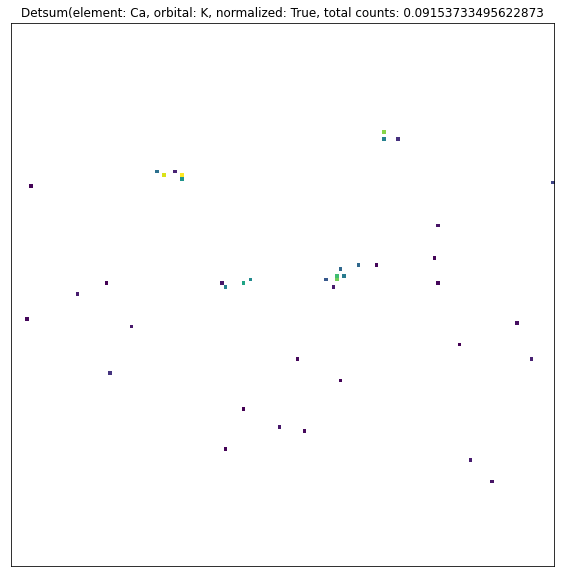

In [23]:
# Filter by Cu and store the new CombinedScan
CombinedScanExample.filtered_cs = CombinedScanExample.cs.filter_by('Cu')

#Plot the filtered Calcium detsum
CombinedScanExample.filtered_cs.get_detsum('Ca')[0].plot(figsize=(10,10))

<h3>Accessing Pixel Data</h3>

This is identical to accessing pixel data from a `Scan` object. You can see in the following example that there are 3 times as many pixels in the `CombinedScan` object as there are in the individual `Scan` objects above.

In [24]:
CombinedScanExample.cs.data.dropna(how='all')

,Ca,Cu,Fe,element_group
24,NaN,NaN,0.001844,Fe
25,NaN,NaN,0.007977,Fe
26,NaN,NaN,0.009031,Fe
27,NaN,NaN,0.003511,Fe
28,NaN,NaN,0.001346,Fe
...,...,...,...,...
68049,0.0919,NaN,NaN,Ca
68055,NaN,0.00564,NaN,Cu
68068,NaN,NaN,0.033800,Fe
68071,NaN,NaN,0.037000,Fe


<h3>Getting Unique Element Groups<h3>

Again, this is done exactly the same way as it is done with a normal `Scan`

In [25]:
# Get element groups, show Cu and Fe counts, and sort by Cu counts
CombinedScanExample.cs.get_unique_groups(elements_to_sum=['Cu', 'Fe'], sort_by='Cu_counts')

,Cu_counts,Fe_counts,num_pixels
element_group,,,
Cu,5.935480,0.000000,3256
Ca|Cu,0.130544,0.000000,138
Cu|Fe,0.123516,2.352480,43
Ca|Cu|Fe,0.005289,0.425304,2
Ca,0.000000,0.000000,1705
Ca|Fe,0.000000,1.627410,36
Fe,0.000000,16.717649,674


### Depth Object

The `Depth` object is mainly responsible for instantiating all `Scan` and `Detsum` objects from the file tree, as well as a single `CombinedScan` object from the created `Scans`.


In [26]:
DepthExample = Namespace()
DepthExample.path = os.path.join(DRIVE_BASE, 'software_development/etsp/XRF data/25m')
DepthExample.d = Depth(DepthExample.path,
                       elements_of_interest=['Cu', 'Ca', 'Fe'],
                       orbitals=['K'],
                       normalized=True)

DepthExample.d

Depth(25m, scans: ['28861', '28903', '21346'])

<h3>Accessing Scans and CombinedScan</h3>

In [27]:
# Getting the CombinedScan
DepthExample.d.combined_scan

CombinedScan
Scan(scan_number: 28861, contained_detsums:
Detsum(element: Ca, orbital: K, normalized: True, total counts: 1.026225390844047
Detsum(element: Cu, orbital: K, normalized: True, total counts: 0.5286776491411729
Detsum(element: Fe, orbital: K, normalized: True, total counts: 0.6252545236493461)
--------------------

Scan(scan_number: 28903, contained_detsums:
Detsum(element: Ca, orbital: K, normalized: True, total counts: 14.91428297990933
Detsum(element: Cu, orbital: K, normalized: True, total counts: 0.18512200471013784
Detsum(element: Fe, orbital: K, normalized: True, total counts: 3.724888182245195)
--------------------

Scan(scan_number: 21346, contained_detsums:
Detsum(element: Ca, orbital: K, normalized: True, total counts: 38.3583
Detsum(element: Cu, orbital: K, normalized: True, total counts: 5.4810300000000005
Detsum(element: Fe, orbital: K, normalized: True, total counts: 16.7727)
--------------------
)

In [28]:
# Getting Scans
DepthExample.d.scans

[Scan(scan_number: 28861, contained_detsums:
 Detsum(element: Ca, orbital: K, normalized: True, total counts: 1.026225390844047
 Detsum(element: Cu, orbital: K, normalized: True, total counts: 0.5286776491411729
 Detsum(element: Fe, orbital: K, normalized: True, total counts: 0.6252545236493461),
 Scan(scan_number: 28903, contained_detsums:
 Detsum(element: Ca, orbital: K, normalized: True, total counts: 14.91428297990933
 Detsum(element: Cu, orbital: K, normalized: True, total counts: 0.18512200471013784
 Detsum(element: Fe, orbital: K, normalized: True, total counts: 3.724888182245195),
 Scan(scan_number: 21346, contained_detsums:
 Detsum(element: Ca, orbital: K, normalized: True, total counts: 38.3583
 Detsum(element: Cu, orbital: K, normalized: True, total counts: 5.4810300000000005
 Detsum(element: Fe, orbital: K, normalized: True, total counts: 16.7727)]

In [29]:
# Getting the third Detsum from the second Scan
DepthExample.d.scans[1].detsums[2]

Detsum(element: Fe, orbital: K, normalized: True, total counts: 3.724888182245195

# Analysis

##Data Import


The following cell will create a list of `Depth` objects to use for analysis. The resulting list will be stored in a variable called `depths`*italicized text*

In [30]:
#@markdown Enter drive path to data folder (do not include 'My Drive/'):
data_path = "software_development/etsp/XRF data/" #@param{type:"string"}
#depth_path = "software_development/etsp/XRF data/25m" #@param {type:"string"}
#@markdown Enter elements separated by comma
ELEMENTS_OF_INTEREST = "Br,Ca,Cu,Fe,K,Mg,Mn,S,Si,Zn" #@param {type:"string"}
ELEMENTS_OF_INTEREST=ELEMENTS_OF_INTEREST.split(',')
ORBITALS = "K" #@param {type:"string"}

def import_data(data_path):
  depths = []
  for d in os.listdir(os.path.join(DRIVE_BASE, data_path)):
    try:
      fullpath = os.path.join(DRIVE_BASE, data_path, d)
      d = Depth(os.path.join(fullpath),
                      ELEMENTS_OF_INTEREST,
                      orbitals=['K'],
                      normalized=True)
      depths.append(d)
      print(f"Successfully imported data for {d.depth}")
    except NameError as e:
      print(e)
      pass
  return depths

depths = import_data(data_path)

Successfully imported data for 165m
Successfully imported data for 250m
Successfully imported data for 900m
Successfully imported data for 65m
Successfully imported data for 50m
/content/gdrive/My Drive/software_development/etsp/XRF data/10m/scan2D_21328 (1) is not a valid name for Scan directory
Successfully imported data for 10m
Successfully imported data for 25m
Successfully imported data for 40m


## Looking for Glitches

Uncomment the last line and run the following cell to plot all `Detsums` from all depths.

In [0]:
def plot_all_detsums(depths):
  detsums = []
  for d in depths:
    these_detsums = [detsum for s in d.scans for detsum in s.detsums]
    detsums += these_detsums

  #return detsums
  ncols = 4
  nrows = 1 + (len(detsums) // ncols)

  g = widgets.Grid(nrows, ncols)
  row = 0
  col = 0
  for i, detsum in enumerate(detsums):
    with g.output_to(row, col):
      print(f'Depth: {detsum.depth}, Scan: {detsum.scan_name}')
      detsum.plot(raw=True)
    if (col + 1) % 4 == 0:
      row += 1
      col = 0
    else:
      col += 1

#Uncomment this line to plot all detsums
#plot_all_detsums(depths)

##Ribbon Plot

The `ribbon_plot` function shows fractional concentration of a given element in various different element groups. 
(will add more on this later)

###Function definition

In [0]:
def ribbon_plot(depths,
                filter_by='Cu',
                ax=None,
                N=8,
                normalize_by='counts'):
  '''Shows fractional concentration of element among different groups.

  Args:
    filter_by: string. Element under investigation
    ax: plt.Axes. Optional Axes to plot on
    N: int. The amount of groups to use. For example, N=12 means "take the
      top 12 groups from each depth"
    normalize_by: string. Which quantity to use for data normalization. This
      can either be 'counts' or 'pixels'.
  '''
  if ax is None:
    fig, ax = plt.subplots(figsize=(16, 4))
  else:
    fig = ax.figure()

  # Sort depth objects by depth
  depths = sorted(depths, key=lambda d: int(d.depth[:-1]), reverse=True)

  # Get a default list of 10 colors. I don't exactly understand *how* this
  # works, but I know that it *does* work. Here is the stack overflow for
  # this: https://stackoverflow.com/questions/49233855/matplotlib-add-more-colors-to-the-default-colors-in-axes-prop-cycle-manually
  colors = plt.cm.tab10(np.arange(10))

  patterns = [None, '///', '..', 'xx', '**', '+++', 'OO', '\\\\\\']
  color_cycler = cycler(facecolor=colors)
  pattern_cycler = cycler(hatch=patterns)

  # Multiplication of cyclers results in the 'outer product'
  # https://matplotlib.org/cycler/
  props = iter(pattern_cycler * color_cycler)


  prop_dict = {}

  for i, depth in enumerate(depths):
    scan = depth.combined_scan
    # Get the unique groups and the total pixels and counts
    if normalize_by == 'pixels':
      sort_by = 'num_pixels'
      col = 'num_pixels'
      normalization = lambda g: g['num_pixels'].sum()
    elif normalize_by == 'counts':
      sort_by = f'{filter_by}_counts'
      col = f'{filter_by}_counts'
      normalization = lambda g: g[f'{filter_by}_counts'].sum()
    else:
      raise ValueError("`normalize_by` must be 'pixels' or 'counts'")

    groups = scan.filter_by(filter_by).get_unique_groups(elements_to_sum=[filter_by], sort_by=sort_by)
    groups[col] /= normalization(groups)

    # Gets the top N unique groups for this scan
    groups = groups.iloc[:N]

    # Assigns a unique color for each group, if the color doesn't exist yet
    for g in groups.index:
      if g not in prop_dict:
        prop_dict[g] = next(props)
        prop_dict[g].update({'alpha': 0.8, 'fill': True, 'edgecolor': 'k'})
        #print(f'Adding {g} to prop_dict')

    left = 0
    thickness = 1

    for group in groups.index:
      #Encode the group value (e.g. Cu|Mn -> 0.0778) as the rectangle width
      rect_width = groups[col].loc[group]
      ax.add_patch(mpatches.Rectangle((left, i-thickness/2),
                             rect_width, thickness,
                             **prop_dict[group]))
      left += rect_width

    t=ax.text(left+0.02, i, f'{col}: {groups[col].sum():0.2f}',
            verticalalignment='center',
            fontsize=10,
            color='black',
            fontweight='bold',
            transform=ax.transData)

    # https://stackoverflow.com/questions/23696898/adjusting-text-background-transparency
    #t.set_bbox({'facecolor':'white', 'alpha':0.8})
    
  # Make the legend using patches. Here is a helpful link
  # https://stackoverflow.com/questions/53849888/make-patches-bigger-used-as-legend-inside-matplotlib
  patches = []
  for group in prop_dict:
    patches.append(mpatches.Patch(
       **prop_dict[group], 
       label=group,
    ))
  leg = ax.legend(handles=patches,
                  bbox_to_anchor=(1.05, 1.2),
                  ncol=len(patches) // 10,
                  labelspacing=2)
  for patch in leg.get_patches():
    patch.set_height(22)
    patch.set_y(-10)
  
  ax.set_yticks(np.arange(0, len(depths)))
  ax.set_yticklabels([d.depth for d in depths])
  ax.set_ylim(-0.5, len(depths)-0.5)
  ax.set_xlim(0, 1.13)
  ax.set_title(f'{filter_by} {normalize_by}', fontsize=16, fontweight='bold')
  plt.show()




### **Plots**

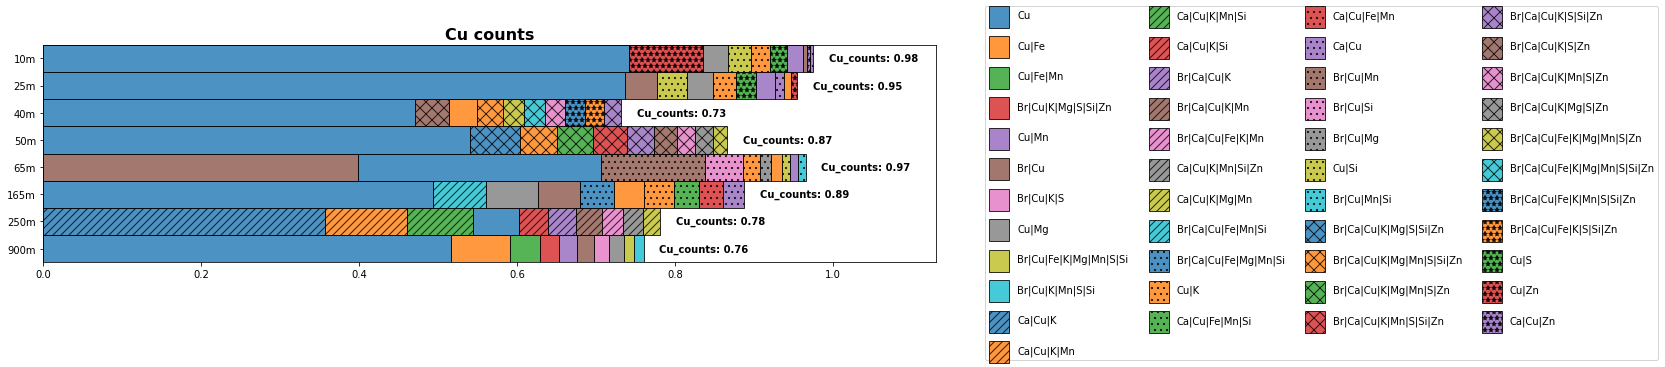

In [33]:
# Filter by Cu, take the top 10 groups. Plot counts
ribbon_plot(depths, filter_by='Cu', normalize_by='counts', N=10)

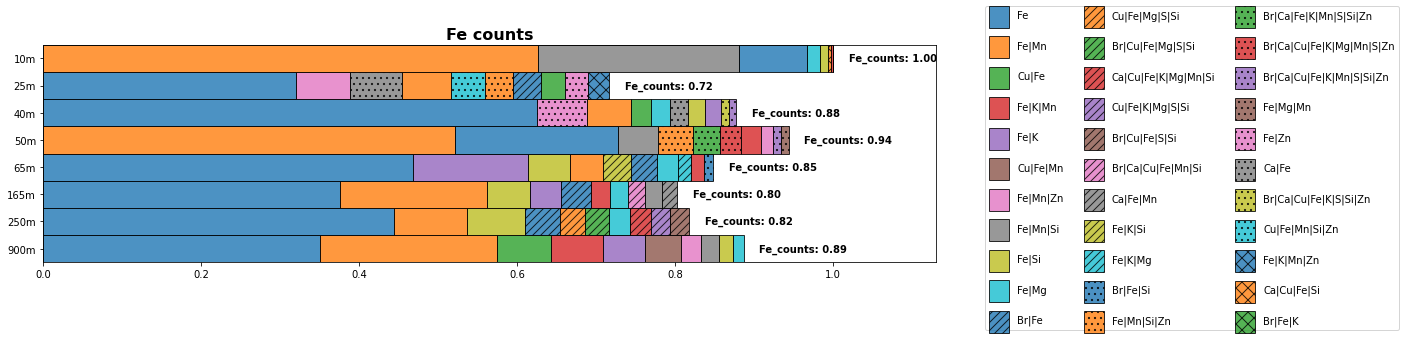

In [35]:
# Filter by Fe, take the top 10 groups. Plot counts
ribbon_plot(depths, filter_by='Fe', normalize_by='counts', N=10)